# RF Power Broadening in PPM Sample

The following demonstrates the broadening of spectral lines in the electronic states of an NV^-1 center in diamond, caused by increasing RF magnetic field power, which controls the transition betweent the ground and excited spin states. 

In the ppm sample used here, two RF-induced resonances were observed about the expected central zero-field split of 2.87 GHz. The double-peak was found for all values of RF power tested. 

This approach uses CW ODMR to measure the reduction in PL as a function of RF frequency and power. For each frequency scan at a particular power, a double lorentzian was fit to the data and the average line-width of both peaks were estimated. 
By varying the RF power, a clear trend of increased line width with increased power was observed.
Extrapolation to zero RF power suggests a minimum line width of 2.5 MHz, which corresponds to a driven decoherence time of $T_{2}^{*} \approx 0.4 \mu s$ (?? 1 /2.5 MHz) for this sample.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import optimize
import copy
from scipy.optimize import leastsq
import scipy 

import logging


In [3]:
import qt3utils.experiments.ramsey
import qt3utils.experiments.cwodmr
import qt3utils.experiments.podmr
import qt3utils.experiments.rabi

from qt3utils.experiments.pulsers.pulseblaster import PulseBlasterRamHahnDD, PulseBlasterCWODMR, PulseBlasterPulsedODMR, PulseBlasterHoldAOM
from qt3utils.analysis.rabi import signal_to_background
import qt3utils.analysis.aggregation
import qt3utils.nidaq
import qcsapphire
import qt3rfsynthcontrol

import nipiezojenapy
import qt3utils.datagenerators as datasources
import qt3utils.datagenerators.piezoscanner
import qt3utils.nidaq.config

# Set Logging Levels

This controls output print statements, which can be useful for debugging and knowing that scans are running

In [4]:
logging.basicConfig(level=logging.WARNING)

In [5]:
qt3utils.experiments.cwodmr.logger.setLevel(logging.WARNING)

# Create objects to control hardware

In [ ]:
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [10]:
aom_hold = PulseBlasterHoldAOM()

In [30]:
aom_hold.program_pulser_state()
aom_hold.start() #do this to during confocal san

In [11]:
cwodmr_pulser = PulseBlasterCWODMR(clock_period = 200e-9)

In [14]:
nidaq_config = qt3utils.nidaq.EdgeCounter('Dev1')

In [15]:
# Eventually, these functions should be moved to the package somewhere -- either analysis or in experiments
def aggregate_data(data_buffer, experiment):
    return data_buffer.reshape(int(experiment.N_cycles), int(experiment.N_clock_ticks_per_cycle)).mean(axis=0)

def podmr_simple_signal_background(trace):
    background = trace[:len(trace)//2]
    signal = trace[len(trace)//2:]
    return np.sum(signal)/np.sum(background)

def cwodmr_simple_signal_background(trace):
    rf_on = trace[:len(trace)//2]
    rf_off = trace[len(trace)//2:]
    return np.sum(rf_on)/np.sum(rf_off)

def measure_cwodrm_contrast(data_buffer, experiment):
    return cwodmr_simple_signal_background(aggregate_data(data_buffer, experiment))

def measure_podmr_contrast(data_buffer, experiment):
    return podmr_simple_signal_background(aggregate_data(data_buffer, experiment))

In [16]:
def plot_contrast_scan(scan, xlabel = 'frequency [Hz]'):
    scan = np.array(scan)

    x_data = scan[:, 0]
    y_data = scan[:, 1]

    plt.figure(figsize=(10, 6))
    plt.plot(x_data, y_data, 'o-', label='Data')

    plt.xlabel(xlabel)

In [156]:
# some fitting functions

def lorentzian( x, center, amplitude, width ):
    return amplitude * width**2 / ( width**2 + ( x - center )**2)

def multi_lorentz( x, *params ):
    off = params[0]
    paramsRest = params[1:]
    assert not ( len( paramsRest ) % 3 )
    return off + sum( [ lorentzian( x, *paramsRest[ i : i+3 ] ) for i in range( 0, len( paramsRest ), 3 ) ] )

def _2_lorentz_fixed_peak_diff(x, *params):
        offset = params[0]
        return offset + lorentzian(x, params[1], params[2], params[3]) + lorentzian(x, params[1] + params[4], params[5], params[6])

def res_multi_lorentz(xData, yData, *params):
    diff = [ multi_lorentz( x, *params ) - y for x, y in zip( xData, yData ) ]
    return diff



In [169]:
#more fitting stuff

def get_pars(p_opt, p_covariance):
    p_errors = np.sqrt(np.diag(p_covariance))

    offset = p_opt[0]
    offset_err = p_errors[0]

    pars_1 = p_opt[1:4]
    errs_1 = p_errors[1:4]
    pars_2 = p_opt[4:7]
    errs_2 = p_errors[4:7]
    
    mean_width  =  np.mean([pars_1[2], pars_2[2]])
    
    return offset, pars_1, pars_2, errs_1, errs_2, mean_width

def fit_double_lorentz(x, y, amp1 = 3, amp2 = 3, cen1 = 2865, cen2 = 2875, wid1 = 10, wid2 = 10, fixed_delta = None):

    params = [0, cen1, amp1, wid1, cen2, amp2, wid2]
    bounds = (0, np.inf)
    
    fit_function = multi_lorentz
    
    if fixed_delta is not None:
        params[4] = fixed_delta
        bounds = (len(params)*[0], len(params)*[np.inf])
        bounds[0][4] = params[4]-1e-10
        bounds[1][4] = params[4]+1e-10
        fit_function = _2_lorentz_fixed_peak_diff
        
    p_opt, p_cov = scipy.optimize.curve_fit(fit_function, x, y, 
                                            p0=params, 
                                            maxfev = 10000, 
                                            bounds = bounds)
    return p_opt, p_cov

# def fit_double_lorentz_with_fixed_peak_diff(x, y, delta, amp1 = 3, amp2 = 3, cen1 = 2865, wid1 = 10, wid2 = 10):
    
#     def _2_lorentz_fixed_peak_diff(x, *params):
#         offset = params[0]
#         return offset + lorentzian(x, params[1], params[2], params[3]) + lorentzian(x, params[1] + delta, params[4], params[5])

#     params = [0, cen1, amp1, wid1, amp2, wid2]
#     p_opt, p_cov = scipy.optimize.curve_fit(_2_lorentz_fixed_peak_diff, x, y, p0=[0, cen1, amp1, wid1, amp2, wid2], maxfev = 10000)
#     return p_opt, p_cov


In [102]:
def plot_fit(x, y, p_opt):
    plt.figure(figsize=(10, 6))

    plt.plot(x, y, 'o-', label='Data')
    plt.plot(x, multi_lorentz(x, *p_opt), 'k--', label='Fit')
    plt.legend()

# Confocal Scan
Either run a scan here in the notebook, or use qt3scan and save. qt3scan was used and we load the scan here.

Laser power was ~30 microWatts (according the to photodiode). This has a large uncertainty, it appears, as repeated readings range +- 10 microWatts


Todo -- calibrate with external power meter

In [31]:
scan_file = 'large_scan_x0t80_y0t57.npy'
confocal_scan = np.load(scan_file)

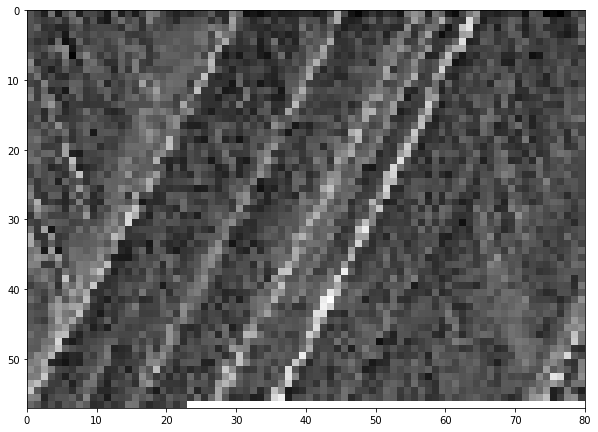

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(confocal_scan, cmap='Greys_r', extent = [0,80,57,0])

In [35]:
scan_file = 'highres_x25t55_y25t55.npy'
confocal_scan = np.load(scan_file)

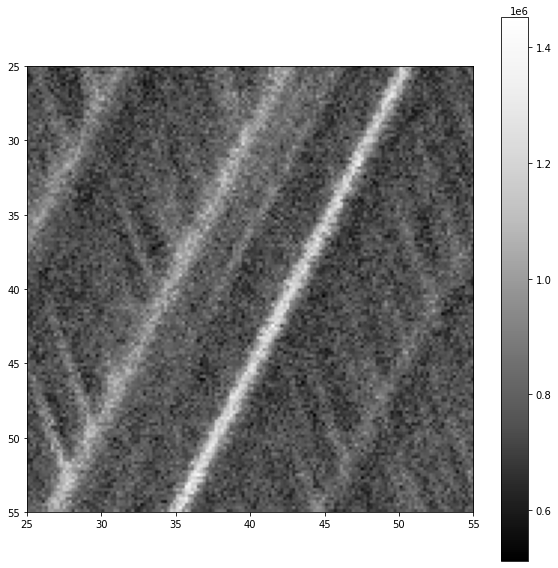

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
artist = ax.imshow(confocal_scan, cmap='Greys_r', extent = [25,55,55,25])
cbar = fig.colorbar(artist, ax=ax)
cbar.formatter.set_powerlimits((0, 3))

In [18]:
#x = 42.1
#y = 40.9
#z = 50 (which is approximately 10 microns below the surface)

In [37]:
cwodmr_exp = qt3utils.experiments.cwodmr.CWODMR(cwodmr_pulser, rfsynth, nidaq_config,
                                                  rf_power=-10)

In [117]:
qt3utils.experiments.cwodmr.logger.setLevel(logging.WARNING)


-5
-7
-9


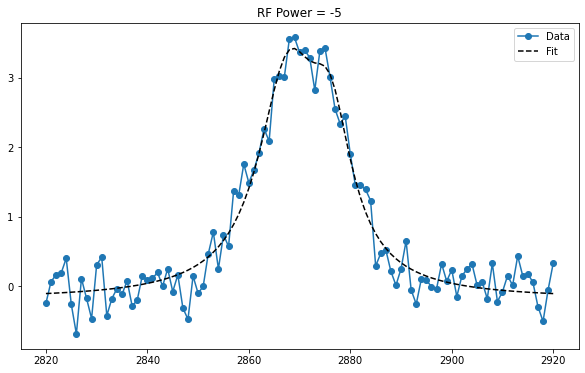

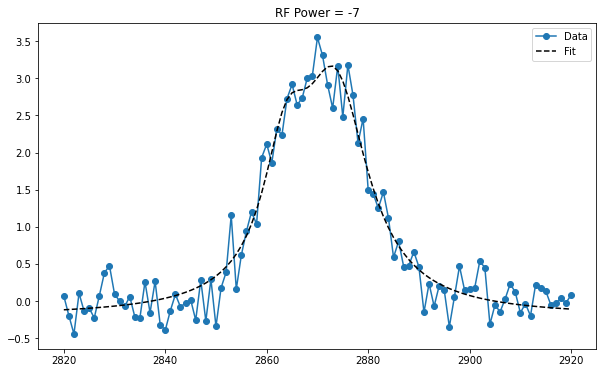

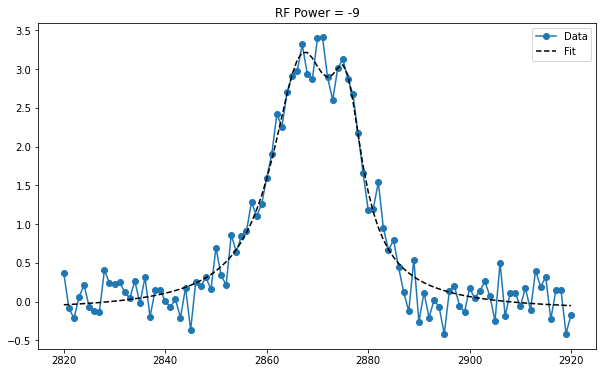

In [120]:
line_widths = {}

for a_pow in [-5, -7, -9]:
    print(a_pow)
    cwodmr_exp.rf_power = a_pow
    cwscan = cwodmr_exp.run(N_cycles=80000, post_process_function=measure_cwodrm_contrast)
    
    cwscan = np.array(cwscan)
    xData = cwscan[:, 0]*1e-6 #in MHz
    yData = cwscan[:, 1]

    yData = 1 - yData
    yData = yData*100
    optimized_p, cov_p = fit_double_lorentz(xData, yData)
    plot_fit(xData, yData, optimized_p)
    mean_width = get_pars(optimized_p, cov_p)[-1] #last parameter returns by this functionis the mean width in MHz
    
    plt.title(f'RF Power = {a_pow}, Line Width = {res["mean_width"]} MHz')
    line_widths[a_pow] = {'p_opt': optimized_p,
                          'p_cov':cov_p,
                          'mean_width':mean_width,
                          'x':xData,
                          'y':yData,
                          'scan':cwscan}

In [125]:
for a_pow in [-12, -15, -18, -20, -22, -25, -28, -30]:
    print(a_pow)
    cwodmr_exp.rf_power = a_pow
    cwscan = cwodmr_exp.run(N_cycles=80000, post_process_function=measure_cwodrm_contrast)
    
    cwscan = np.array(cwscan)
    xData = cwscan[:, 0]*1e-6 #in MHz
    yData = cwscan[:, 1]

    yData = 1 - yData
    yData = yData*100
    optimized_p, cov_p = fit_double_lorentz(xData, yData)
    mean_width = get_pars(optimized_p, cov_p)[-1] #last parameter returns by this functionis the mean width in MHz
    
    line_widths[a_pow] = {'p_opt': optimized_p,
                          'p_cov':cov_p,
                          'mean_width':mean_width,
                          'x':xData,
                          'y':yData,
                          'scan':cwscan}

-12
-15
-18
-20
-22
-25
-28
-30


In [142]:
#with reduced counts, we need to fix the width of the double peaks based on brighter data
#for lower power RF scan below, the delta between the peaks will be fixed
central_peak_deltas = []

for a_pow, res in line_widths.items():
    if a_pow >= -25:
        offset, pars_1, pars_2, errs_1, errs_2, mean_width = get_pars(res['p_opt'], res['p_cov'])
        delta = pars_2[0] - pars_1[0]
        central_peak_deltas.append(delta)
   

In [143]:
np.mean(central_peak_deltas)

7.70649840339441

In [174]:
for a_pow in [-28, -30, -32, -35]:
    print(a_pow)
    cwodmr_exp.rf_power = a_pow
    cwodmr_exp.freq_low = 2845e6
    cwodmr_exp.freq_high = 2895e6
    cwscan = cwodmr_exp.run(N_cycles=500000, post_process_function=measure_cwodrm_contrast)
    
    cwscan = np.array(cwscan)
    xData = cwscan[:, 0]*1e-6 #in MHz
    yData = cwscan[:, 1]

    yData = 1 - yData
    yData = yData*100
    
    optimized_p, cov_p = fit_double_lorentz(xData, yData, fixed_delta = np.mean(central_peak_deltas))
    mean_width = get_pars(optimized_p, cov_p)[-1] #last parameter returns by this functionis the mean width in MHz

    line_widths[a_pow] = {'p_opt': optimized_p,
                          'p_cov':cov_p,
                          'mean_width':mean_width,
                          'x':xData,
                          'y':yData,
                          'scan':cwscan,
                          'fixed_delta':np.mean(central_peak_deltas)}

-28
-30
-32
-35


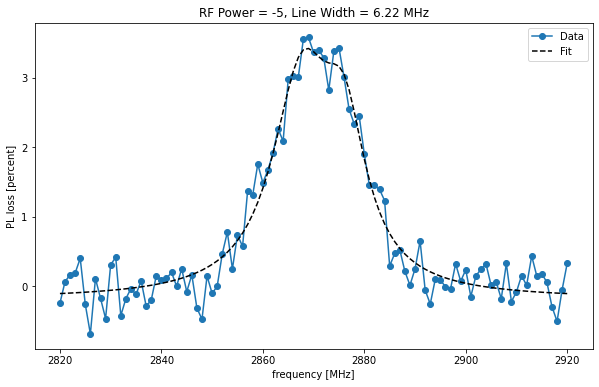

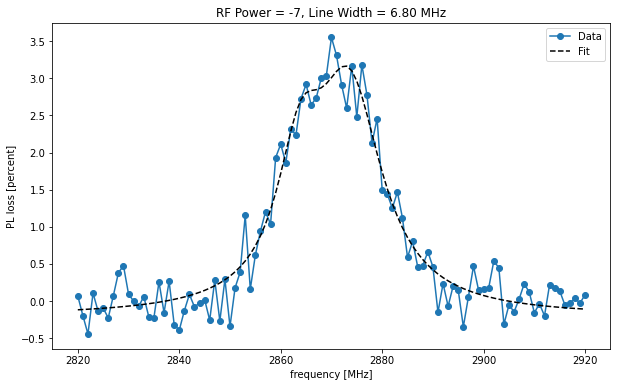

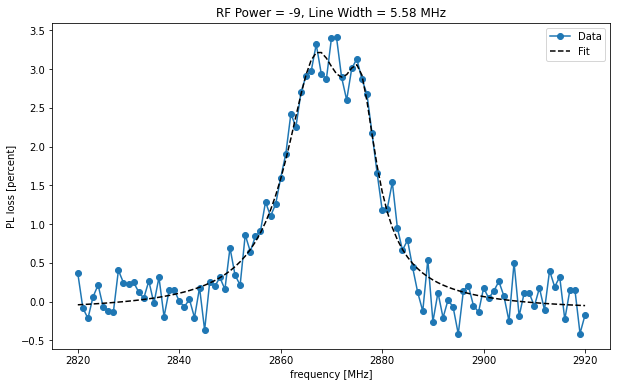

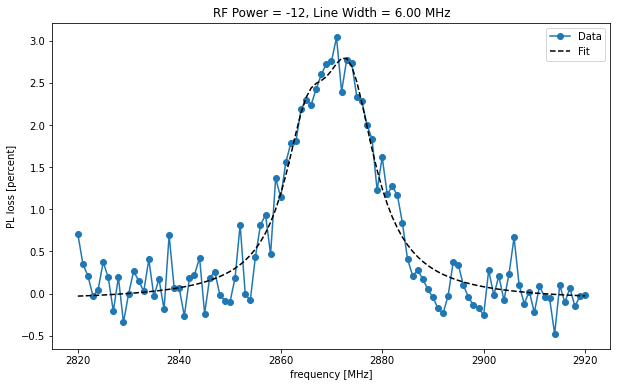

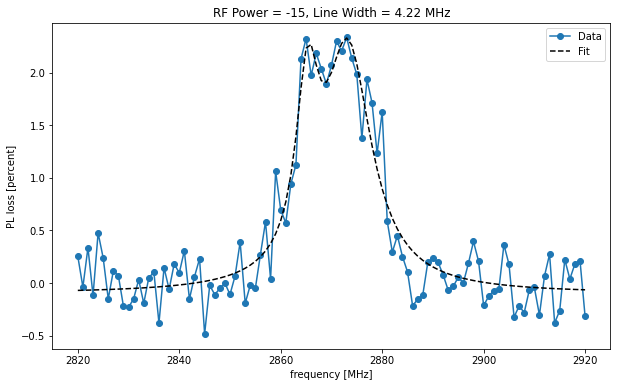

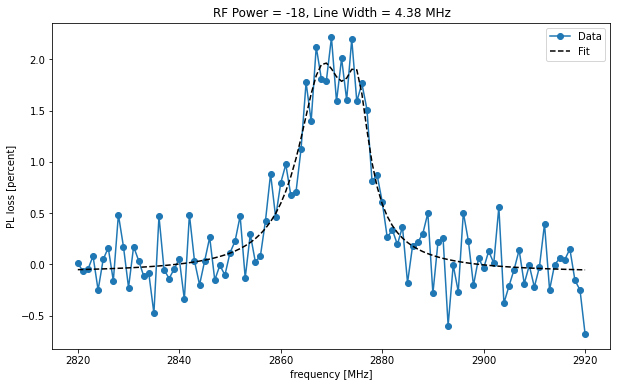

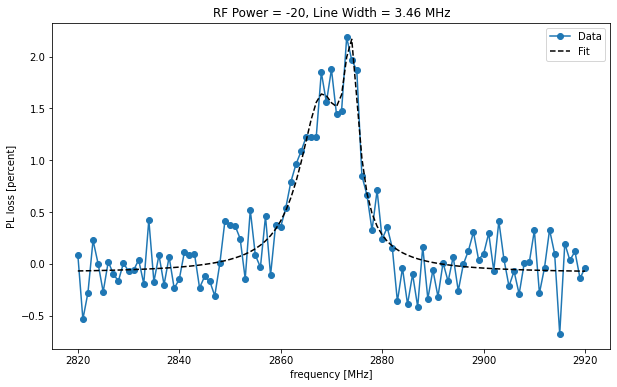

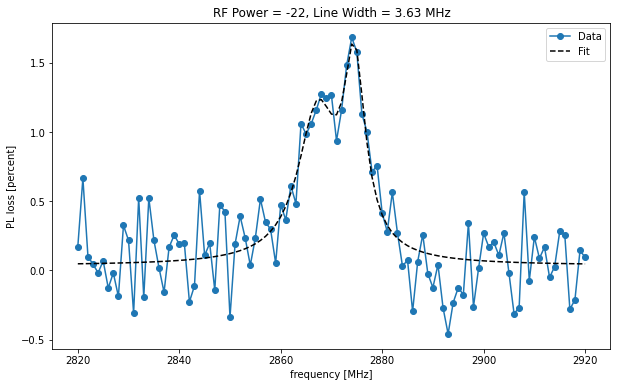

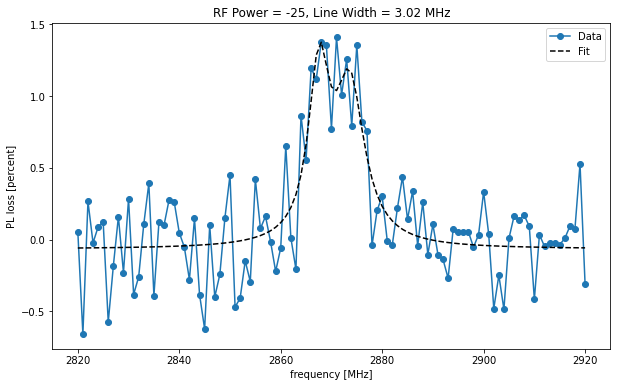

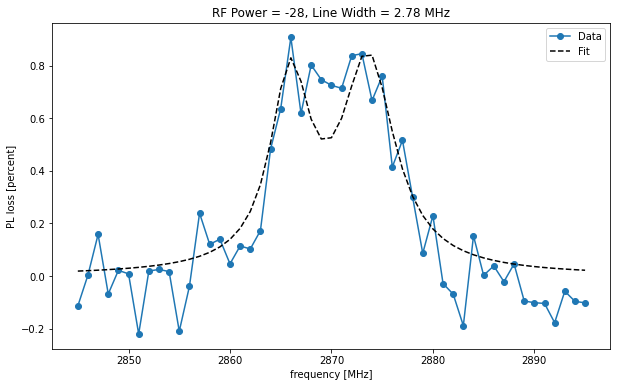

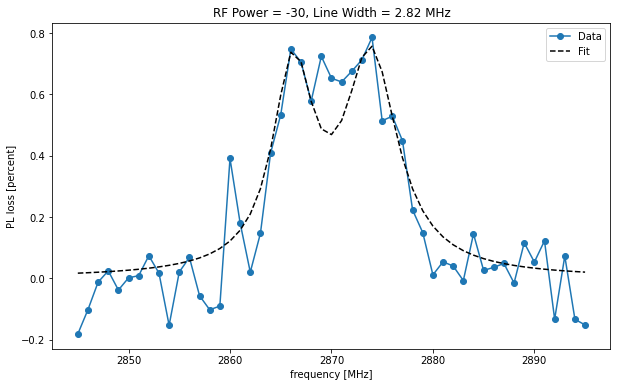

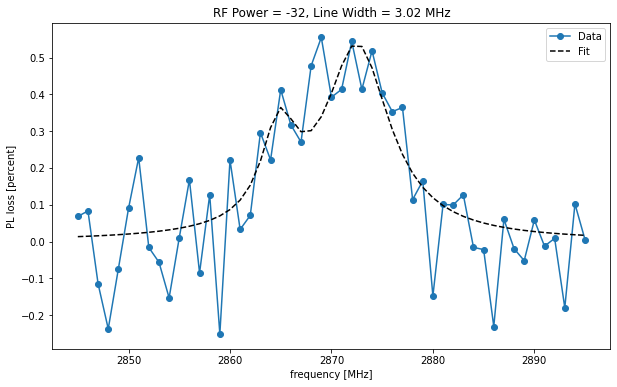

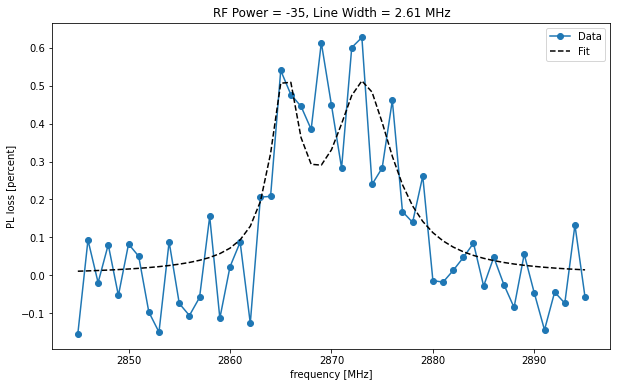

In [175]:

rf_power_line_width = []

for a_pow, res in line_widths.items():
    fixed_delta = res.get('fixed_delta', 0)
    opt_p = copy.deepcopy(res['p_opt'])
    if fixed_delta != 0:
        opt_p[4] = opt_p[1] + fixed_delta
    plot_fit(res['x'], res['y'], opt_p)
    plt.title(f'RF Power = {a_pow}, Line Width = {res["mean_width"]:0.2f} MHz')
    plt.xlabel('frequency [MHz]')
    plt.ylabel('PL loss [percent]')
    rf_power_line_width.append([a_pow, res['mean_width']])
    


Text(0, 0.5, 'linewidth [MHz]')

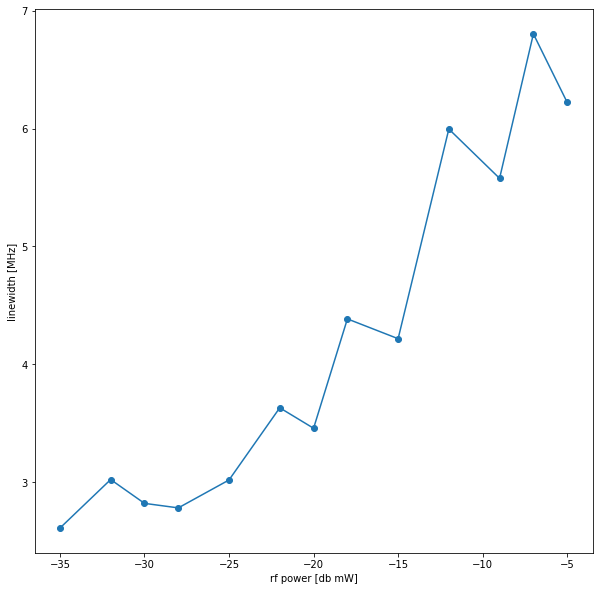

In [183]:

plt.figure(figsize=(10,10))
rf_power_line_width = np.array(rf_power_line_width)

plt.plot(rf_power_line_width[:, 0], rf_power_line_width[:, 1], 'o-', label='Data')
plt.xlabel('rf power [db mW]')
plt.ylabel('linewidth [MHz]')

In [177]:
import pickle

In [178]:
save_data_name = 'rf_power_broadening_ppmsample.oct21.2022.pickle'

In [179]:
def save_file(name, data):
    with open(name, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_file(name):
    with open(name, 'rb') as handle:
        return pickle.load(handle)

In [180]:
save_file(save_data_name, line_widths)

In [ ]:
for a_pow in [-35, -38, -40, -45]:
    print(a_pow)
    cwodmr_exp.rf_power = a_pow
    cwscan = cwodmr_exp.run(N_cycles=1000000, post_process_function=measure_cwodrm_contrast)
    
    cwscan = np.array(cwscan)
    xData = cwscan[:, 0]*1e-6 #in MHz
    yData = cwscan[:, 1]

    yData = 1 - yData
    yData = yData*100

    optimized_p, cov_p = fit_double_lorentz(xData, yData, fixed_delta = np.mean(central_peak_deltas))
    mean_width = get_pars(optimized_p, cov_p)[-1] #last parameter returns by this functionis the mean width in MHz

    line_widths[a_pow] = {'p_opt': optimized_p,
                          'p_cov':cov_p,
                          'mean_width':mean_width,
                          'x':xData,
                          'y':yData,
                          'scan':cwscan}

-35
-38


In [ ]:
save_file(save_data_name, line_widths)

In [ ]:

rf_power_line_width = []

for a_pow, res in line_widths.items():
    fixed_delta = res.get('fixed_delta', 0)
    opt_p = copy.deepcopy(res['p_opt'])
    if fixed_delta != 0:
        opt_p[4] = opt_p[1] + fixed_delta
    plot_fit(res['x'], res['y'], opt_p)
    plt.title(f'RF Power = {a_pow}, Line Width = {res["mean_width"]:0.2f} MHz')
    plt.xlabel('frequency [MHz]')
    plt.ylabel('PL loss [percent]')
    rf_power_line_width.append([a_pow, res['mean_width']])
    


In [ ]:
plt.figure(figsize=(10,10))
rf_power_line_width = np.array(rf_power_line_width)

plt.plot(rf_power_line_width[:, 0], rf_power_line_width[:, 1], 'o-', label='Data')
plt.xlabel('rf power [db mW]')
plt.ylabel('linewidth [MHz]')